In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import bs4 as bs
import requests

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2020,8,31)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [4]:
#Slice Open Prices
sp500_open=data.iloc[:, data.columns.get_level_values(0)=='Open']
sp500_open.head()
#Slice Adj. Close Prices
sp500_adjclose=data.iloc[:, data.columns.get_level_values(0)=='Adj Close']
#sp500_adjclose.dropna(axis = 1, inplace = True)
sp500_adjclose.head()

sp500_adjclose.drop(['BF.B','BRK.B'], axis=1, level=1,inplace = True)
sp500_adjclose.shape

(168, 503)

In [5]:
# Scrap sp500 tickers
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))
        
    return tickers

tickers = save_sp500_tickers()

In [ ]:
prices = yf.download(tickers, start='2020-01-01')['Adj Close'] 

In [9]:
rs = sp500_adjclose.apply(np.log).diff(1)

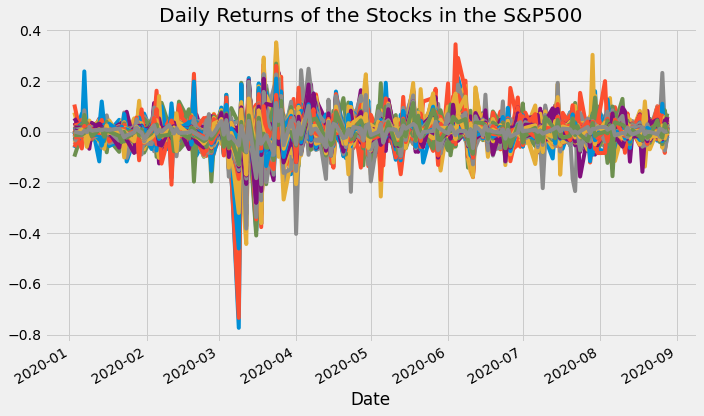

In [110]:
rs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

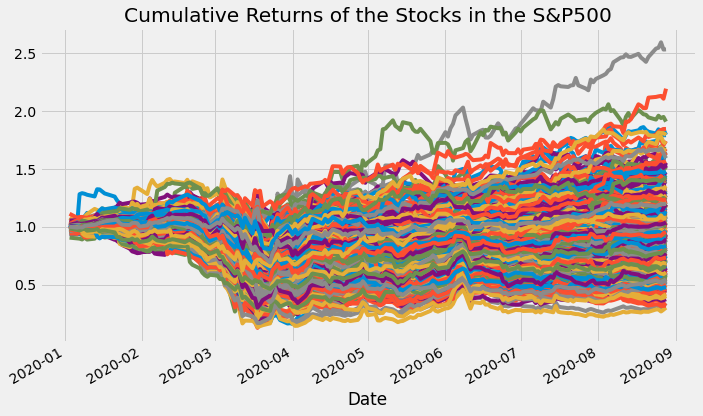

In [111]:
(rs.cumsum().apply(np.exp)).plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the Stocks in the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

In [114]:
from sklearn.decomposition import PCA

In [115]:
pca = PCA(1).fit(rs.fillna(0))

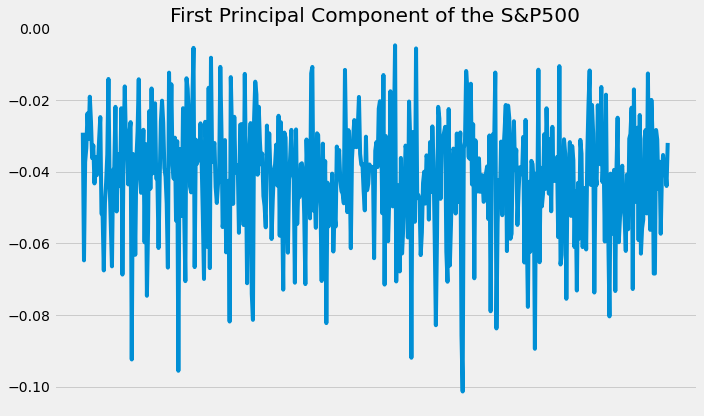

In [116]:
#index_column = rs.columns.droplevel(level=0)

pc1 = pd.Series(index=rs.columns, data=pca.components_[0])

#pc1 = pd.Series(index=index_column, data=pca.components_[0])

pc1.plot(figsize=(10,6), xticks=[], grid=True, title='First Principal Component of the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

<AxesSubplot:xlabel='Date'>

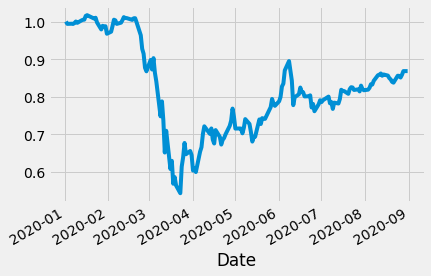

In [117]:
weights = abs(pc1)/sum(abs(pc1))
myrs = (weights*rs).sum(1)
myrs.cumsum().apply(np.exp).plot()

In [118]:
prices = yf.download(['SPY'], start=start, end=end)['Adj Close'] 

[*********************100%***********************]  1 of 1 completed


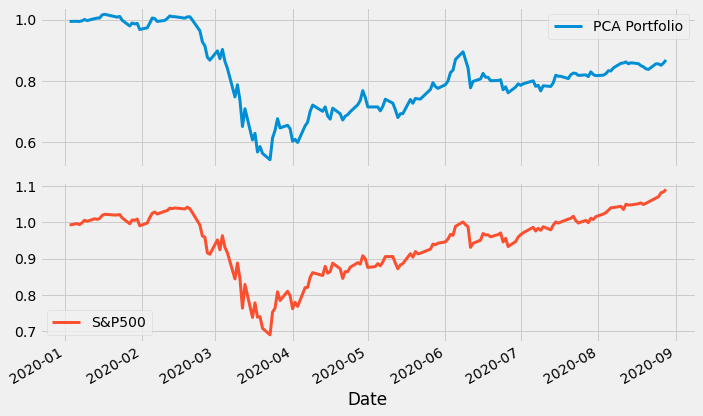

In [119]:
rs_df = pd.concat([myrs, prices.apply(np.log).diff(1)], 1)
rs_df.columns = ["PCA Portfolio", "S&P500"]

rs_df.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3);
plt.tight_layout()
plt.savefig('tmp.png')

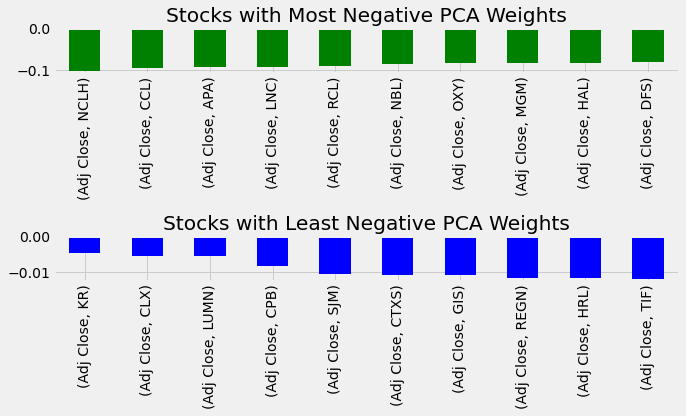

In [120]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')

plt.tight_layout()
plt.savefig('tmp.png')

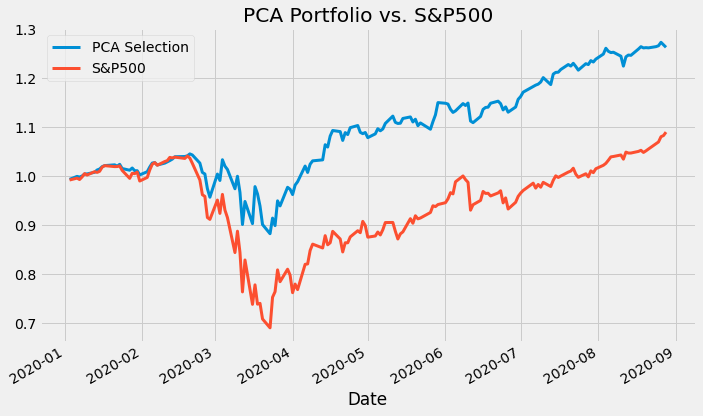

In [121]:
# ws = [-1,]*10+[1,]*10
# myrs = (rs[list(pc1.nsmallest(10).index)+list(pc1.nlargest(10).index)]*ws).mean(1)
myrs = rs[pc1.nlargest(50).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices['2020':].apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()
plt.savefig('tmp.png')

In [122]:
stock_list = pc1.nlargest(50)

In [123]:
print (stock_list)

Adj Close  KR     -0.004683
           CLX    -0.005386
           LUMN   -0.005545
           CPB    -0.008148
           SJM    -0.010488
           CTXS   -0.010697
           GIS    -0.010716
           REGN   -0.011486
           HRL    -0.011539
           TIF    -0.011698
           NEM    -0.011851
           OTIS   -0.012282
           CAG    -0.012310
           GILD   -0.012499
           WMT    -0.012541
           DPZ    -0.012653
           K      -0.012975
           DG     -0.013558
           CHD    -0.013879
           AKAM   -0.014072
           ATVI   -0.014159
           EA     -0.014831
           NLOK   -0.015405
           CARR   -0.015558
           AMZN   -0.016152
           TTWO   -0.016317
           COST   -0.016531
           NFLX   -0.016618
           BDX    -0.016726
           CHRW   -0.016858
           VZ     -0.016991
           KMB    -0.017505
           EBAY   -0.018418
           TYL    -0.018469
           ABMD   -0.019033
           INCY   -0

In [124]:
stock_list = stock_list.index.droplevel(level=0)

In [125]:
stock_list

Index(['KR', 'CLX', 'LUMN', 'CPB', 'SJM', 'CTXS', 'GIS', 'REGN', 'HRL', 'TIF',
       'NEM', 'OTIS', 'CAG', 'GILD', 'WMT', 'DPZ', 'K', 'DG', 'CHD', 'AKAM',
       'ATVI', 'EA', 'NLOK', 'CARR', 'AMZN', 'TTWO', 'COST', 'NFLX', 'BDX',
       'CHRW', 'VZ', 'KMB', 'EBAY', 'TYL', 'ABMD', 'INCY', 'WST', 'BMY', 'JNJ',
       'LLY', 'CL', 'BIO', 'TGT', 'TMO', 'PFE', 'TSCO', 'PG', 'ED', 'ALXN',
       'MKC'],
      dtype='object')

In [126]:
import warnings
warnings.filterwarnings('ignore')

In [127]:
import pandas as pd

# read_html allows us to get all <table> tags from a website and outputs a list of DataFrames
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') 
SP500_df = table[0]
security_basket = SP500_df['Symbol'].to_list()
security_basket[:5]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN']

In [128]:
security_basket = stock_list.tolist()

print (security_basket)

['KR', 'CLX', 'LUMN', 'CPB', 'SJM', 'CTXS', 'GIS', 'REGN', 'HRL', 'TIF', 'NEM', 'OTIS', 'CAG', 'GILD', 'WMT', 'DPZ', 'K', 'DG', 'CHD', 'AKAM', 'ATVI', 'EA', 'NLOK', 'CARR', 'AMZN', 'TTWO', 'COST', 'NFLX', 'BDX', 'CHRW', 'VZ', 'KMB', 'EBAY', 'TYL', 'ABMD', 'INCY', 'WST', 'BMY', 'JNJ', 'LLY', 'CL', 'BIO', 'TGT', 'TMO', 'PFE', 'TSCO', 'PG', 'ED', 'ALXN', 'MKC']
